# Utilisation de ffmpeg dans le projet Meteorix

In [1]:
from IPython.display import Image

### Objectif

Notre objectif est d'adresser une puce matérielle pour encoder une vidéo à partir d'images brutes. En effet, sur le nano-satellite nous aurons uniquement une puce pour faire l'encodage de la vidéo. Pour tester cela nous allons utiliser FFMPEG avec différentes options pour voir comment sont encodés les images.

### 1.Transformer une vidéo compressé au format ppm

Pour le moment nous avons des vidéos dans des formats compressés, or la caméra du satellite récupère des images au format ppm. Nous voulons donc transformer nos vidéos compressés en image ppm pour ensuite donner ces image à la puce pour qu'elle les compresse.

La commande suivante permet de le faire : mkdir -p output_images && ffmpeg -i video.mpg output_images/image%d.ppm

Elle stocke aussi toutes les vidéos dans un dossier output

### 2. Copier les images sur la machine EM780

Nous allons copier les vidéos sur une le disque dur d'une machine qui à les encodeurs similaires à celle que l'on a sur le satellite.

Pour se connecter à la machine : ssh em780.mono.lip6.ext

Il faut faire les commandes suivantes :
- (en local) scp le-fichier-sur-le-mac em780.mono.lip6.ext:~/
- (sur em780) mv v03.mp4 /scratch/renaudc-nfs
Puis on va dans notre dossier cd /scratch/renaudc-nfs pour travailler sur nos dossiers

De plus, FFMPEG est déjà installé sur la machine, on pourra donc transférer la vidéo et faire les commandes FFMPEG depuis la machine.

### 3.Encoder les images ppm
- adresser la puce sur le GPU embarqué AMD Radeon 780M (avec VAAPI)
- adresser la puce sur le GPU externe NVidia GeForce RTX 3090 (dans ce cas il faut utiliser NVENC)

L'option 1 est la meilleure car la puce est sur le SoC, ce qui sera probablement plus proche de la réalité dans un nano-satellite.
L'option 2 serai certainement plus facile car NVENC est bien supporté et documenté en général

####  3.1 NVidia GeForce RTX 3090
On peut encoder avec la commande : ffmpeg -hwaccel cuda -framerate 30 -i output_images/image%d.ppm -c:v h264_nvenc -preset fast -b:v 5M compressed_video.mp4 -loglevel verbose

-hwaccel cuda : Active l'accélération matérielle CUDA pour optimiser le traitement.

-c:v h264_nvenc : Utilise NVENC pour encoder la vidéo au format H.264.

-preset : permet de changer la vitesse de compression des images, on met slow pour mieux voir l'utilisation du gpu.

On peut stocker l'utilisation du GPU avec la première commande :\
nohup watch -n 1 nvidia-smi > gpu_usage.log & \
ffmpeg -hwaccel cuda -i output_images/image%d.ppm -c:v h264_nvenc -preset slow compressed_video.mp4

On regarde l'utilisation du gpu avant et pedant l'éxécution de ffmpeg :

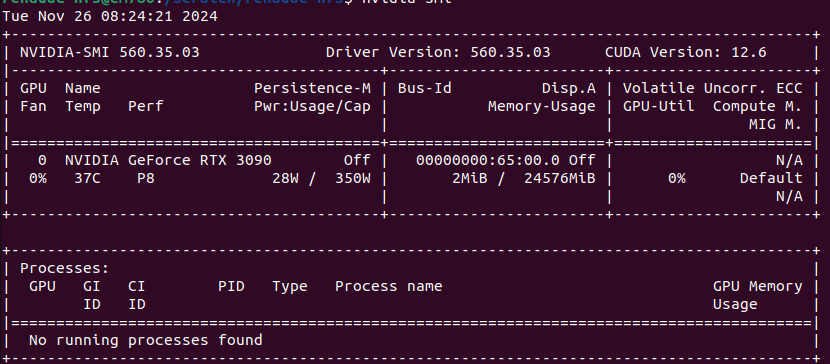

In [ ]:
Image("../utilisationGPU/nvidia-smi_avant.png") 

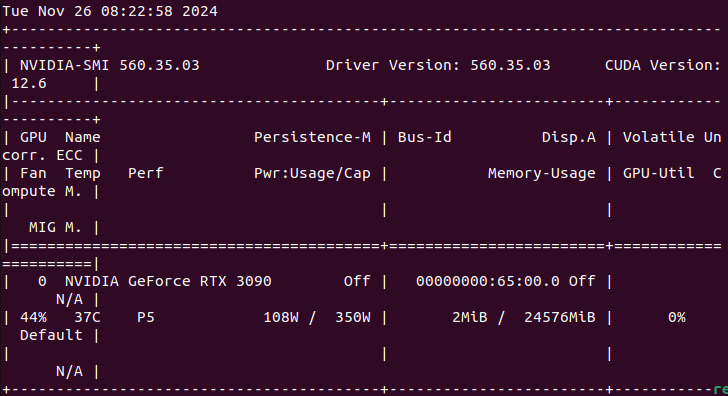

In [ ]:
Image("../utilisationGPU/nvidia-smi_pendant.png")

On remarque une augmentation de 80 watts, cette augmentation peut varie un peu à chaque éxécution

On peut aussi utiliser l'utilisation de nvtop pour voir l'utilisation du gpu en direct

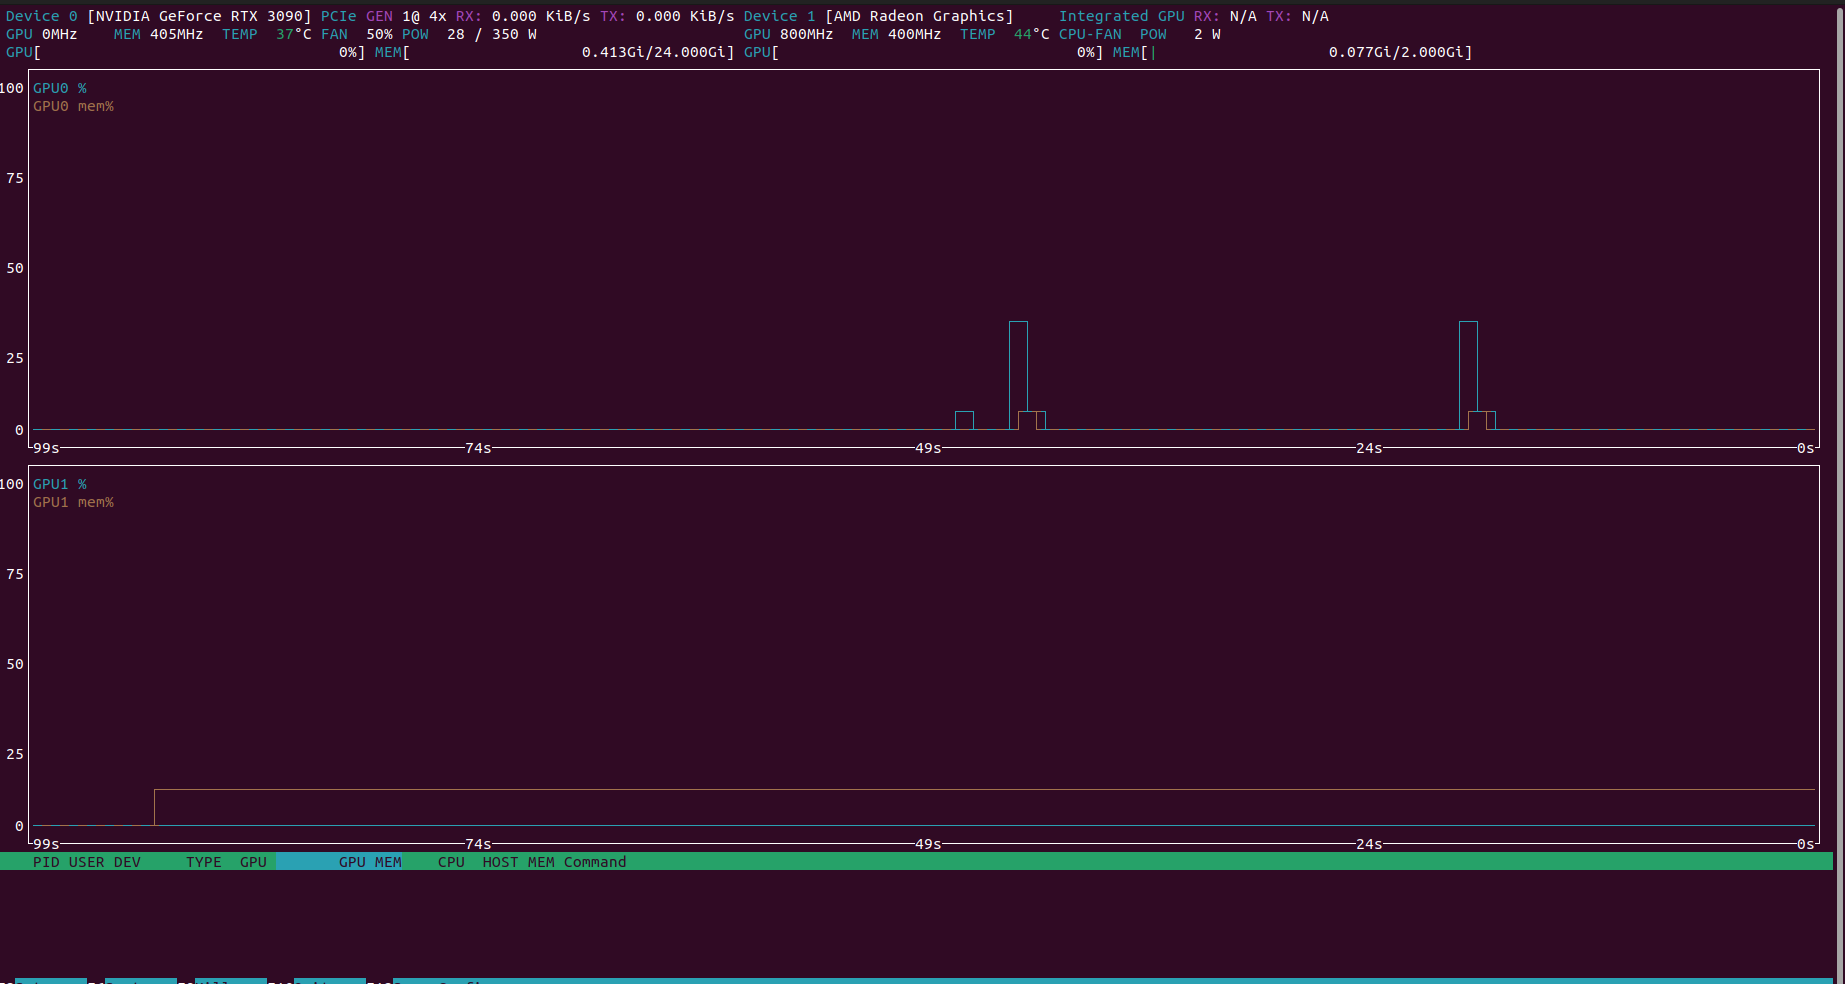

In [ ]:
Image("../utilisationGPU/ffmpegNVIDIA_ecran.png") 

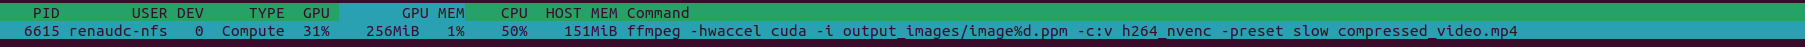

In [ ]:
Image("../utilisationGPU/ffmpegNVIDIA_commande.png") 

On remarque donc que ffmpeg utilise les capacités du gpu

####  3.2 AMD Radeon 780M

On va utiliser la bibliothèque VAAPI pour compresser les images ppm.

Avec la commande suivante on va utiliser AMD Radeon 780M

ffmpeg -vaapi_device /dev/dri/renderD128 \
  -i output_images/image%d.ppm \
  -vf 'format=nv12,hwupload' \
  -c:v h264_vaapi -qp 24 -preset fast compressed_video.mp4

Explication des options :

    -vaapi_device /dev/dri/renderD128 : Spécifie le périphérique VAAPI à utiliser.
    -vf 'format=nv12,hwupload' : Convertit les images au format compatible VAAPI (nv12) et les télécharge sur le GPU.
    -c:v h264_vaapi : Utilise VAAPI pour encoder en H.264.
    -qp 24 : Définit la qualité (QP). Ajustez entre 20 (qualité élevée) et 35 (compression élevée).
    -preset fast : Définit une vitesse d'encodage optimisée.

On a cette erreur :
Failed to initialise VAAPI connection: -1 (unknown libva error).\
Device creation failed: -5.\
Failed to set value '/dev/dri/renderD128' for option 'vaapi_device': Input/output error\

AVec ffmpeg -hwaccels, l'accélération devrait être supporté.
